In [1]:
import os
import pandas as pd
import seaborn as sns

In [2]:
# os.chdir("Logic-LLM/")

In [3]:
import re
import json
import os
import argparse

def get_choice(answer_str):
    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'A)', 'B)', 'C)', 'D)', 'E)', 'F)', 'G)', 'H)', 
               'A.', 'B.', 'C.', 'D.', 'E.', 'F.', 'G.', 'H.']
    
    if answer_str is None:
        return ''
    answer_str=answer_str.strip()
    
    for c in choices:
        if answer_str.startswith(c):
            return c.replace(')', '')

    if answer_str.startswith(':'):
       return answer_str.replace(':', '').replace('.', '').strip()
    return ''

def evaluate_QA(QA_results):
    total_em = 0.0
    not_in_options = 0.0
    count = 0
    for sample in QA_results:
        gold_answer = sample['answer'].replace('(', '').replace(')', '').strip()
        answer_str = sample['predicted_answer'].strip() if sample['predicted_answer'] is not None else ''
        prediction = get_choice(answer_str)

        indicators = ['the correct option is', 'the correct answer is', 
                      'The correct answer is', 'The correct option is',
                      'Thus, the answer is']
        if prediction is None:
            for indicator in indicators:
                if answer_str.find(indicator)>=0:
                    answer_str = answer_str.split(indicator)[1].strip()
                    prediction = get_choice(answer_str)
                    break

        if prediction is None:
            not_in_options+=1
            
        em_score = 1.0 if prediction == gold_answer else 0.0
        total_em += em_score
        count += 1
    
    if count!=0:
        avg_em = total_em / count
    else:
        avg_em = 0
    return avg_em

def full_evaluation(result_file):
    with open(result_file, 'r') as f:
        all_samples = json.load(f)

    executable_samples = [sample for sample in all_samples if sample['flag'] == 'success']
    return evaluate_QA(all_samples), len(executable_samples)/len(all_samples), evaluate_QA(executable_samples)

In [4]:
df_main = pd.DataFrame(columns=["model","iteration","split","iteration","exec_rate","exec_accuracy","accuracy"])

In [5]:
df_all=[]
for file in os.listdir("./outputs/results"):
    if "mini_test" in file:
        continue

    if "Bloke" in file:
        continue

    if "checkpoint" in file:
        continue
    
    mode, dataset, split, model = file.split("_")
    model = model[:-5]
    result_file = os.path.join("./outputs/results",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()

    df=pd.DataFrame(all_samples)
    df["clean_answer"] = df.predicted_answer.apply(get_choice)
    df = df.drop(columns=["question","predicted_reasoning", "predicted_answer"])
    df["answer"] = df.answer.str.replace('(', '').replace(')', '')
    df["is_correct"] = df.answer == df.clean_answer
    df["is_empty"] = df.clean_answer == ''
    df["mode"] = mode
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model
    df["refiment"] = 0
    df_all.append(df)

In [6]:
df_all2=pd.concat(df_all)

In [7]:
df_all2.loc[df_all2.is_correct,:]

,id,answer,flag,clean_answer,is_correct,is_empty,mode,dataset,split,model,refiment
10,FOLIO_dev_10,B,Direct,B,True,False,Direct,FOLIO,dev,meta-llama-Llama-2-70b-hf,0
11,FOLIO_dev_11,C,Direct,C,True,False,Direct,FOLIO,dev,meta-llama-Llama-2-70b-hf,0
44,FOLIO_dev_44,B,Direct,B,True,False,Direct,FOLIO,dev,meta-llama-Llama-2-70b-hf,0
59,FOLIO_dev_59,C,Direct,C,True,False,Direct,FOLIO,dev,meta-llama-Llama-2-70b-hf,0
67,FOLIO_dev_67,C,Direct,C,True,False,Direct,FOLIO,dev,meta-llama-Llama-2-70b-hf,0
...,...,...,...,...,...,...,...,...,...,...,...
483,ProofWriter_RelNoneg-OWA-D5-781_Q8,B,Direct,B,True,False,Direct,ProofWriter,dev,meta-llama-Llama-2-70b-hf,0
498,ProofWriter_RelNoneg-OWA-D5-251_Q10,B,Direct,B,True,False,Direct,ProofWriter,dev,meta-llama-Llama-2-70b-hf,0
505,ProofWriter_RelNeg-OWA-D5-731_Q5,A,Direct,A,True,False,Direct,ProofWriter,dev,meta-llama-Llama-2-70b-hf,0
517,ProofWriter_RelNoneg-OWA-D5-739_Q12,B,Direct,B,True,False,Direct,ProofWriter,dev,meta-llama-Llama-2-70b-hf,0


In [8]:
(df_all2.clean_answer=="").mean()

0.44814814814814813

In [9]:
df_all3=df_all2.groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

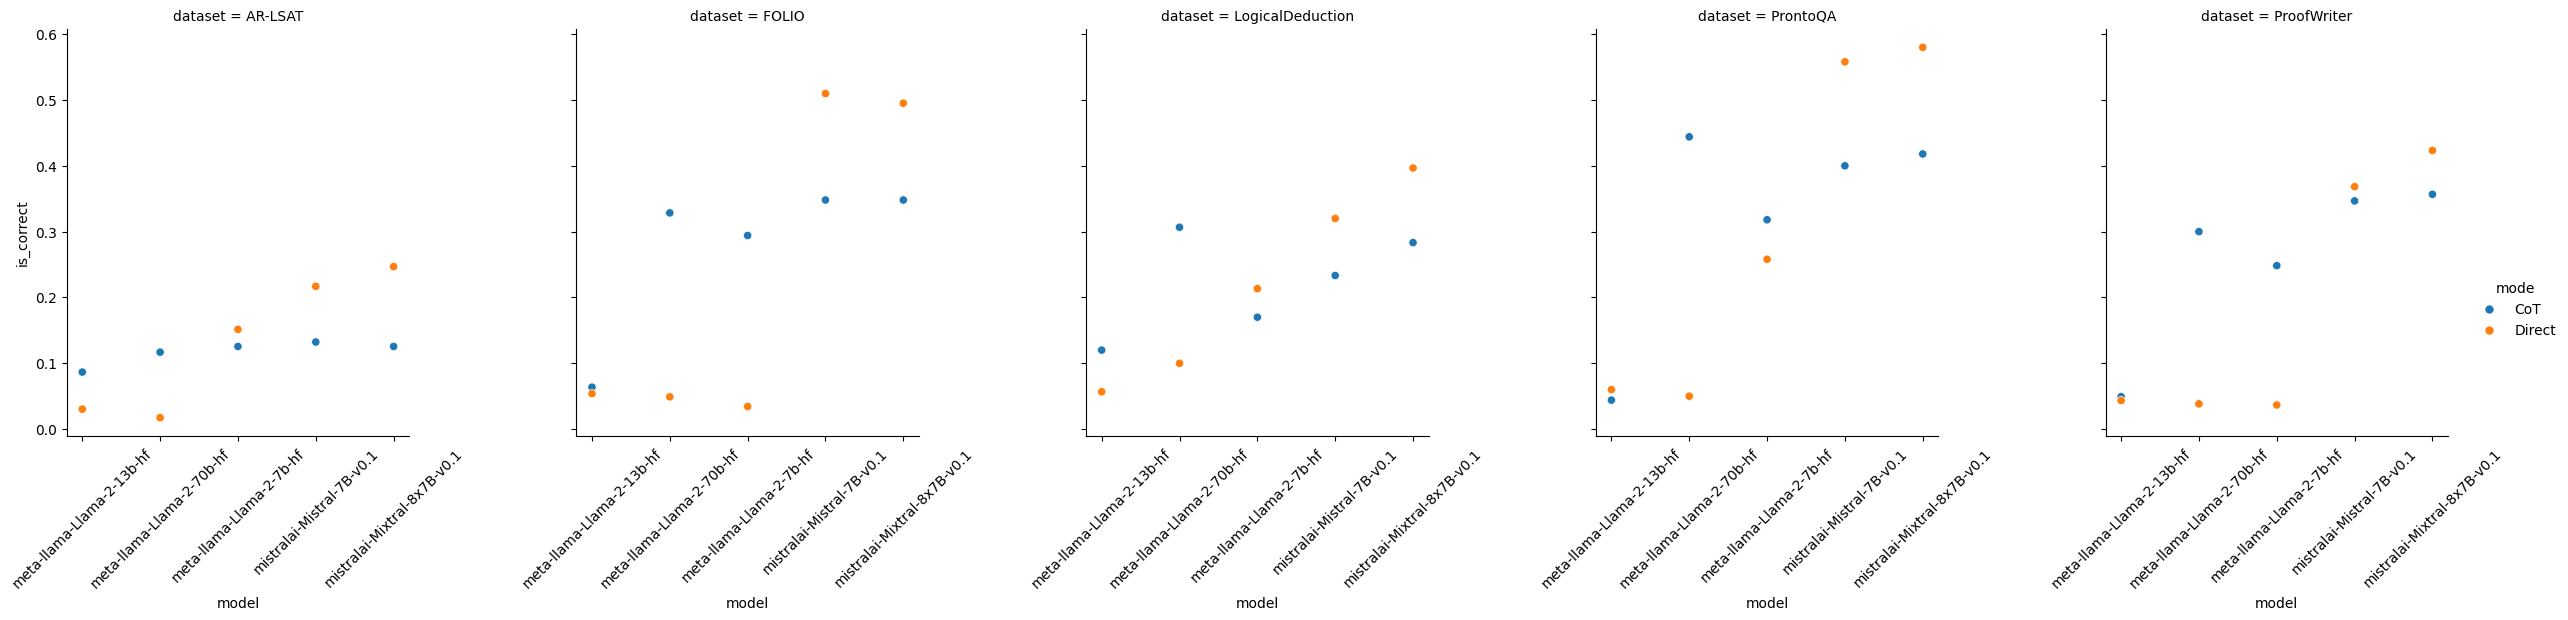

In [10]:
sns.relplot(data=df_all3,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

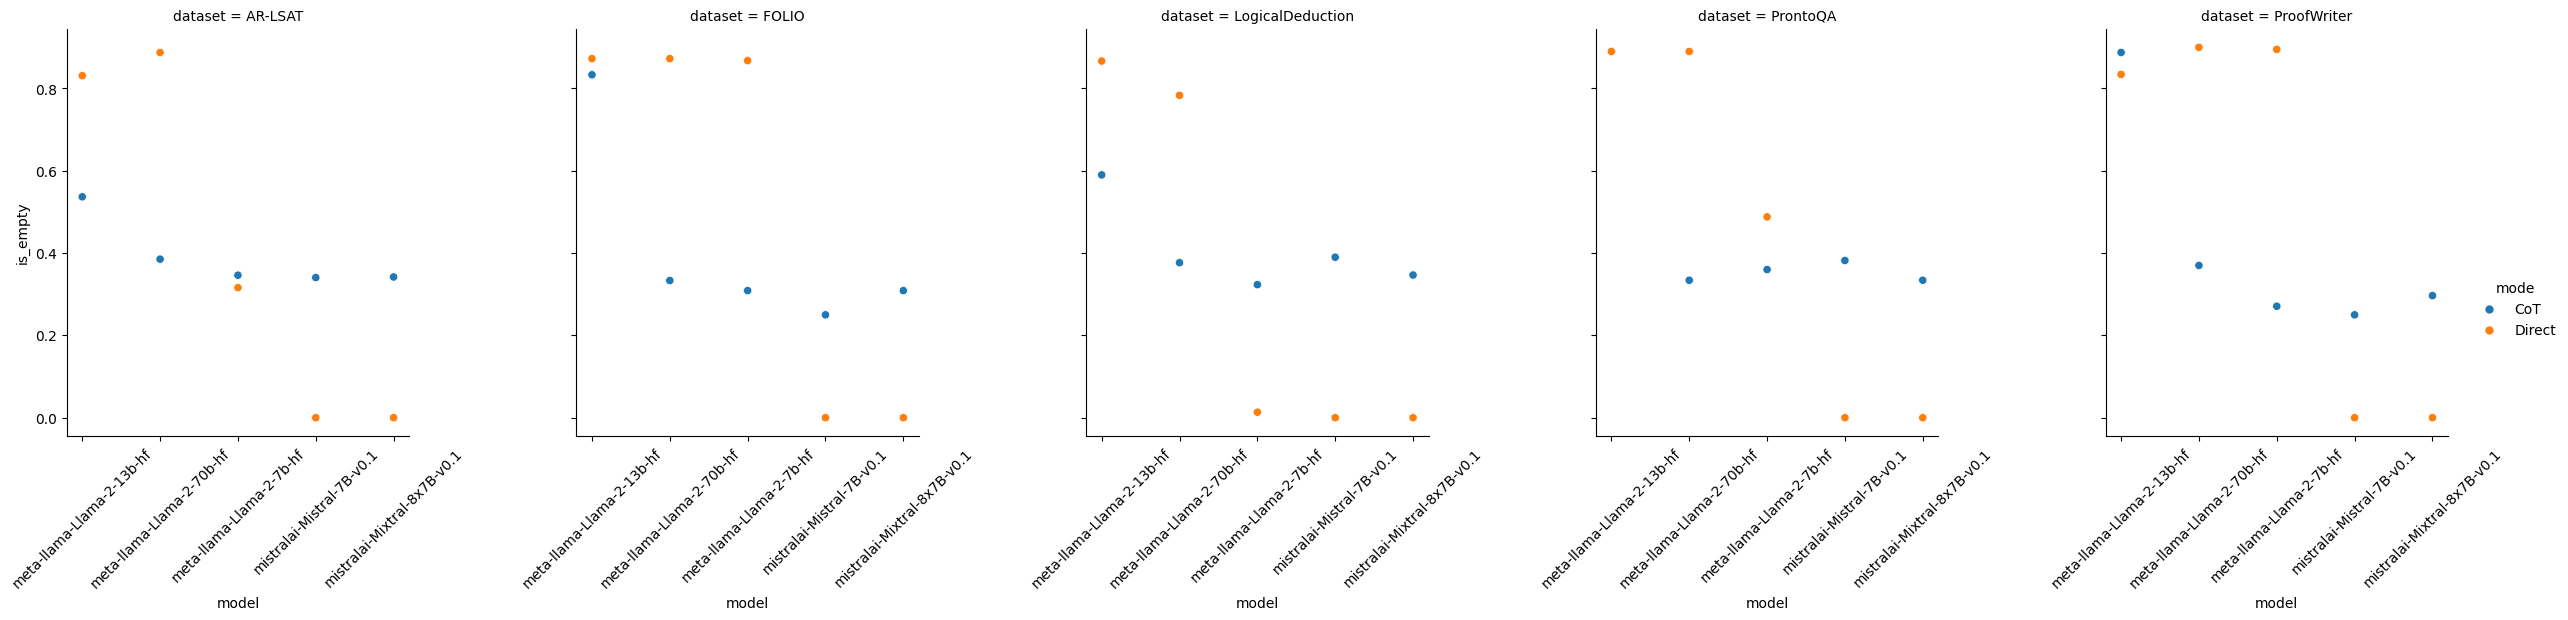

In [11]:
sns.relplot(data=df_all3,x="model",y="is_empty",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [12]:
df_all4=df_all2.loc[df_all2.is_empty!=True,:].groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

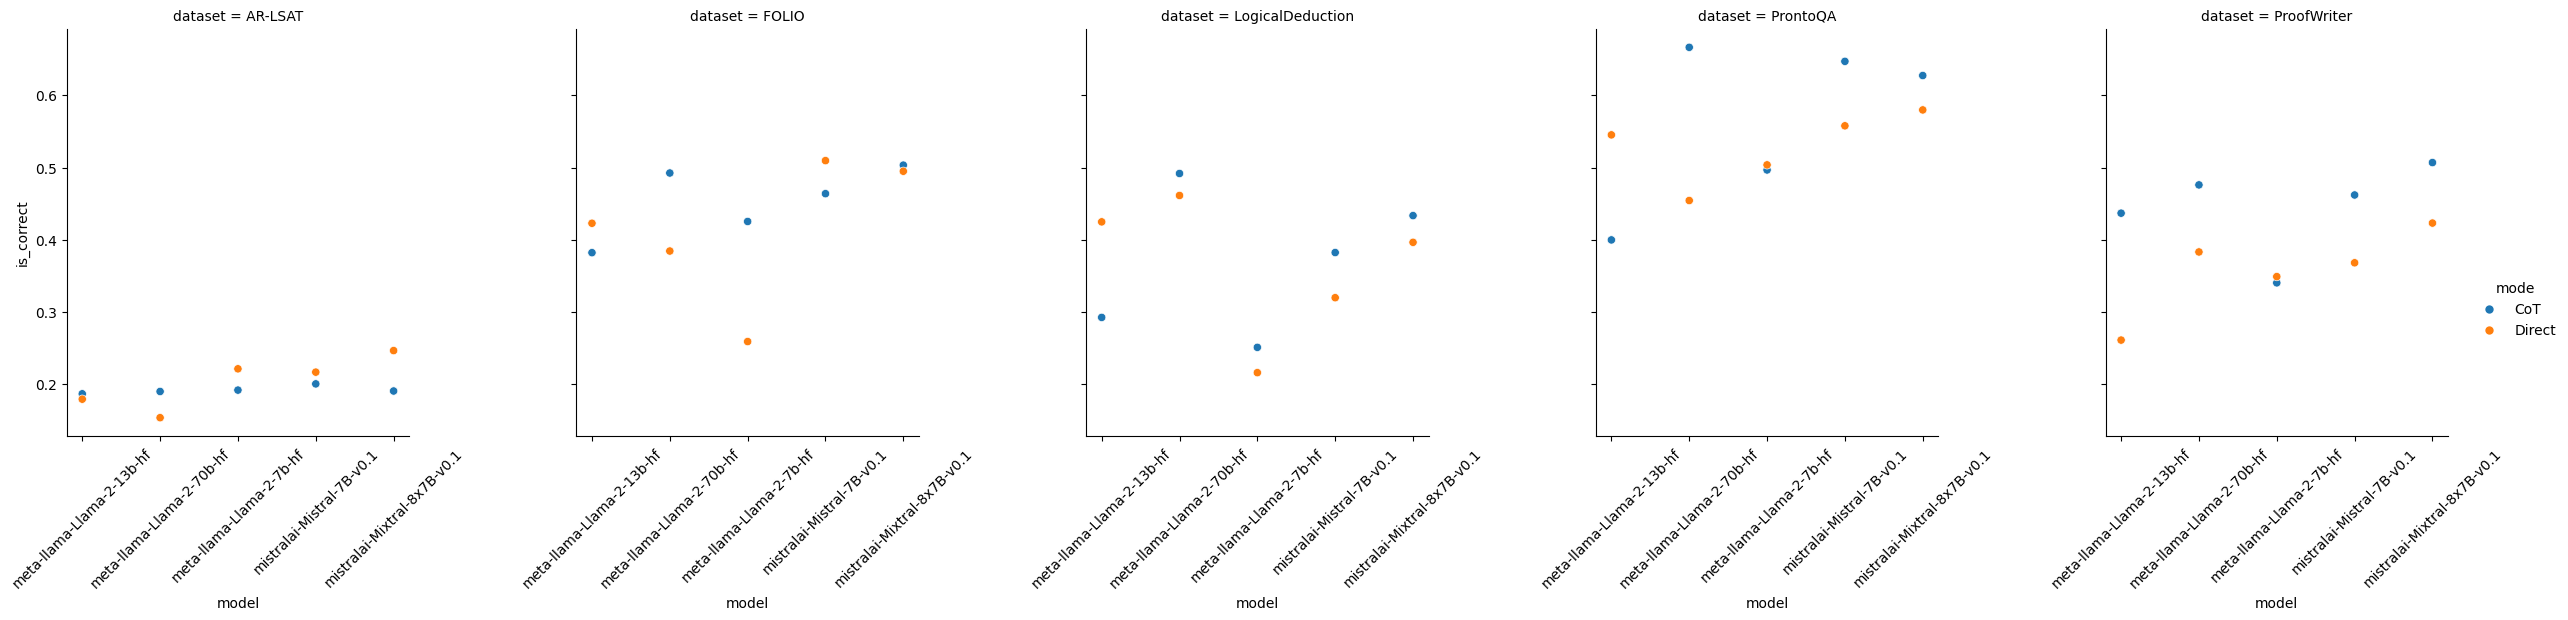

In [13]:
sns.relplot(data=df_all4,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [14]:
df_logic=[]
for file in os.listdir("./outputs/logic_inference"):
    if "mini_test" in file:
        continue

    if "Bloke" in file:
        continue

    # if "backup-random" in file:
    #     continue

    if "checkpoint" in file:
        continue

    if 'self-refine' in file:
        refine, dataset, split, model, backup = file.split("_")
        refine = int(refine.split('-')[-1])
    else:
        dataset, split, model, backup = file.split("_")
        refine = 0
    
    result_file = os.path.join("./outputs/logic_inference",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()

    df=pd.DataFrame(all_samples)
    df["clean_answer"] = df.predicted_answer.apply(get_choice)
    df = df.drop(columns=["question", "predicted_answer","context"])
    df["answer"] = df.answer.str.replace('(', '').replace(')', '')
    df["is_correct"] = df.answer == df.clean_answer
    df["is_empty"] = df.clean_answer == ''
    df["mode"] = 'Logic'
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model
    df["refiment"] = refine
    df_logic.append(df)

JSONDecodeError: Expecting value: line 290 column 22 (char 48231)

In [ ]:
df_programs=[]
for file in os.listdir("./outputs/logic_programs"):
    if "mini_test" in file:
        continue

    if "Bloke" in file:
        continue

    # if "backup-random" in file:
    #     continue

    if "checkpoint" in file:
        continue

    if 'self-refine' in file:
        refine, dataset, split, model = file.split("_")
        refine = int(refine.split('-')[-1])
    else:
        dataset, split, model = file.split("_")
        refine = 0
    
    result_file = os.path.join("./outputs/logic_programs",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()

    df=pd.DataFrame(all_samples)
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model[:-5]
    df["refiment"] = refine
    df_programs.append(df)

In [15]:
df_logic2=pd.concat(df_logic)

In [16]:
df_total2 = pd.concat([df_all2,df_logic2])

In [17]:
df_total5 = df_total2.loc[df_total2["mode"] == "Logic",:]

In [18]:
fails = df_total5.loc[df_total5["flag"] != "success",:].groupby(["model","dataset","refiment"])[["flag"]].count()

In [19]:
total = df_total5.groupby(["model","dataset","refiment"])[["flag"]].count()

In [20]:
compilation_rate = (total-fails)/total

In [21]:
df_total5.loc[df_total5["flag"] == "success",:].groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

,model,dataset,mode,is_correct,is_empty
0,mistralai-Mixtral-8x7B-v0.1,LogicalDeduction,Logic,0.291946,0.647651
1,mistralai-Mixtral-8x7B-v0.1,ProntoQA,Logic,0.666667,0.000000


In [22]:
print(compilation_rate.to_string())

                                                                              flag
model                                          dataset          refiment          
meta-llama-Llama-2-13b-hf                      ProofWriter      0         0.000000
                                                                1         0.000000
mistralai-Mistral-7B-v0.1-ProofWriter-sft-best ProofWriter      0         0.000000
mistralai-Mixtral-8x7B-v0.1                    LogicalDeduction 0         0.993333
                                               ProntoQA         0         0.012000


In [23]:
df_total3=df_total2.groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

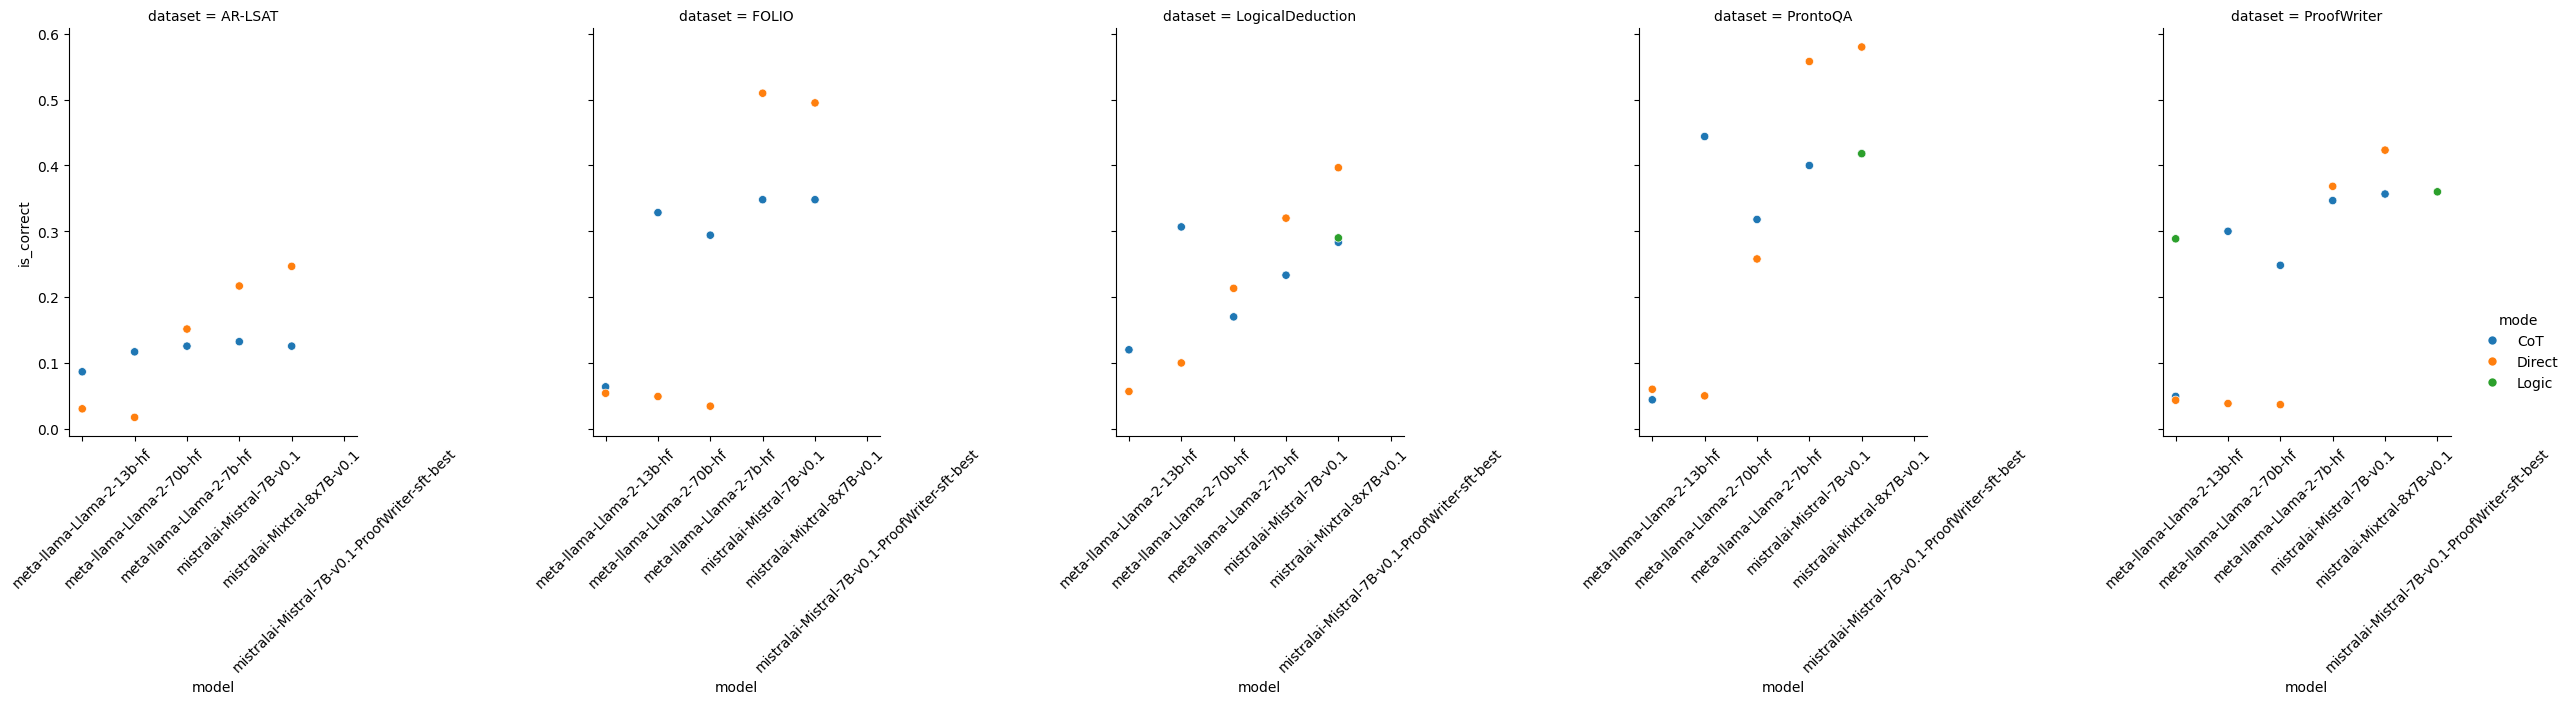

In [24]:
sns.relplot(data=df_total3,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

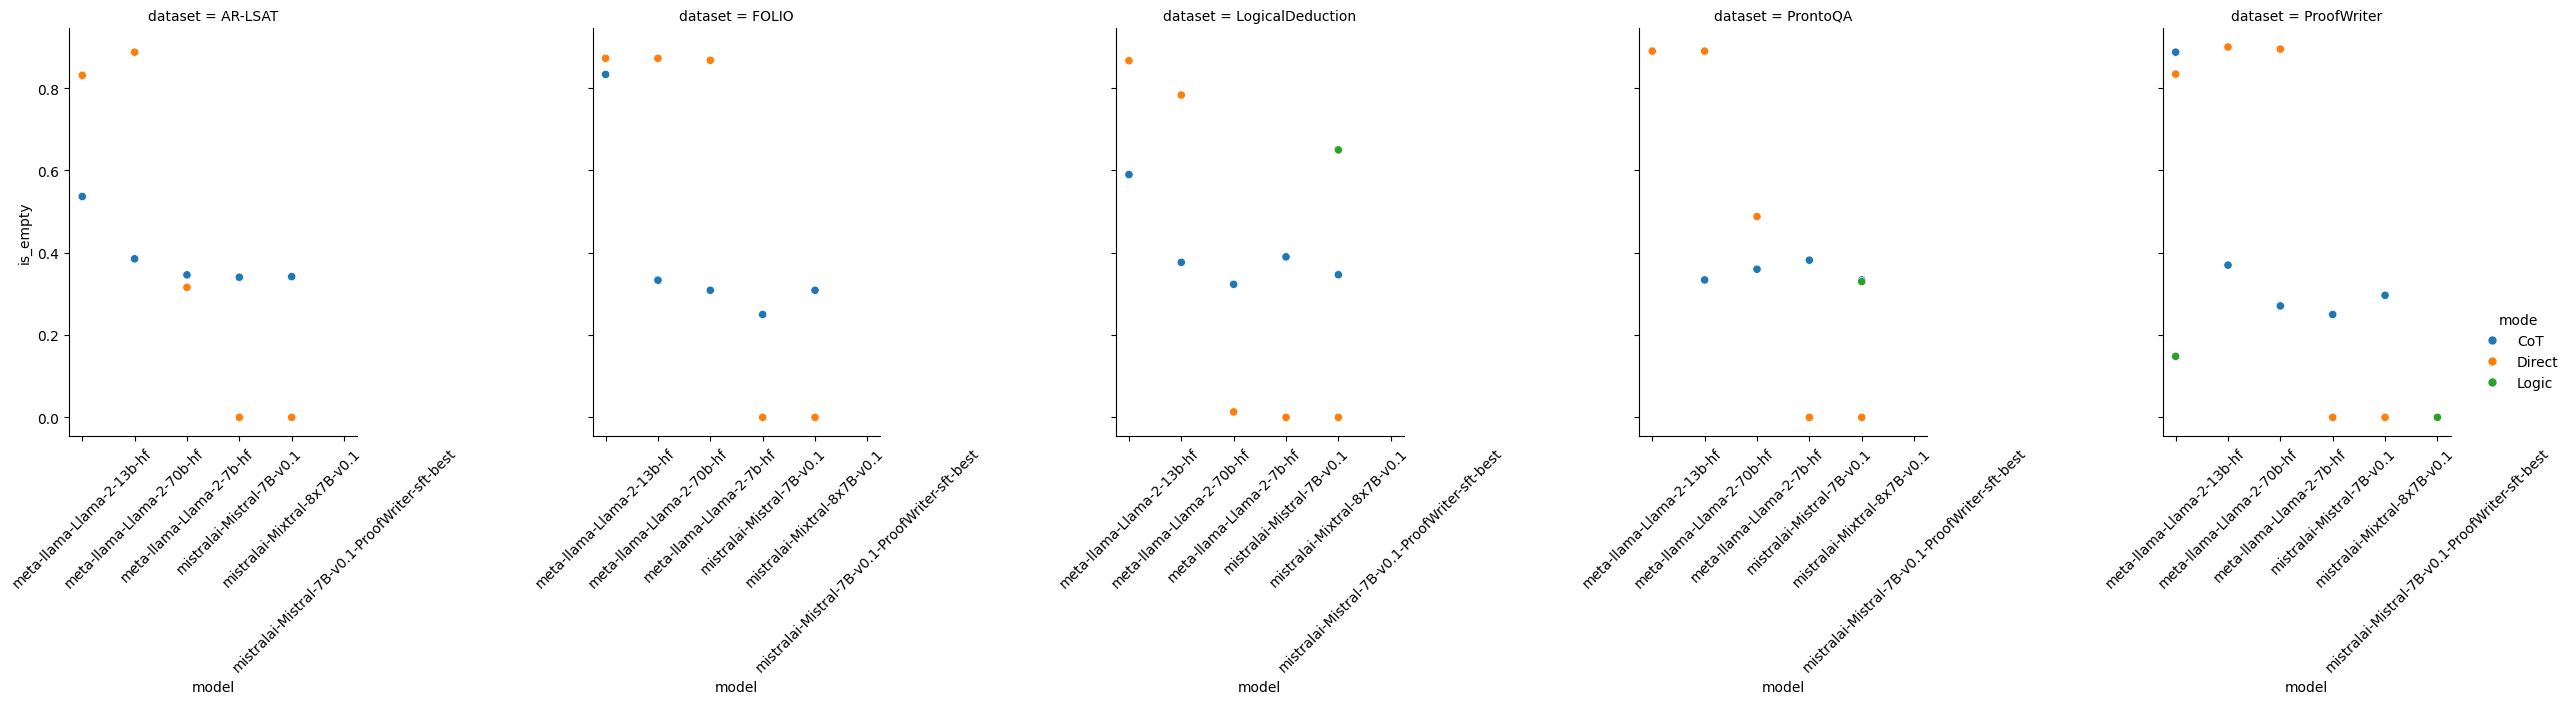

In [25]:
sns.relplot(data=df_total3,x="model",y="is_empty",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [26]:
df_total4=df_total2.loc[df_total2.is_empty!=True,:].groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

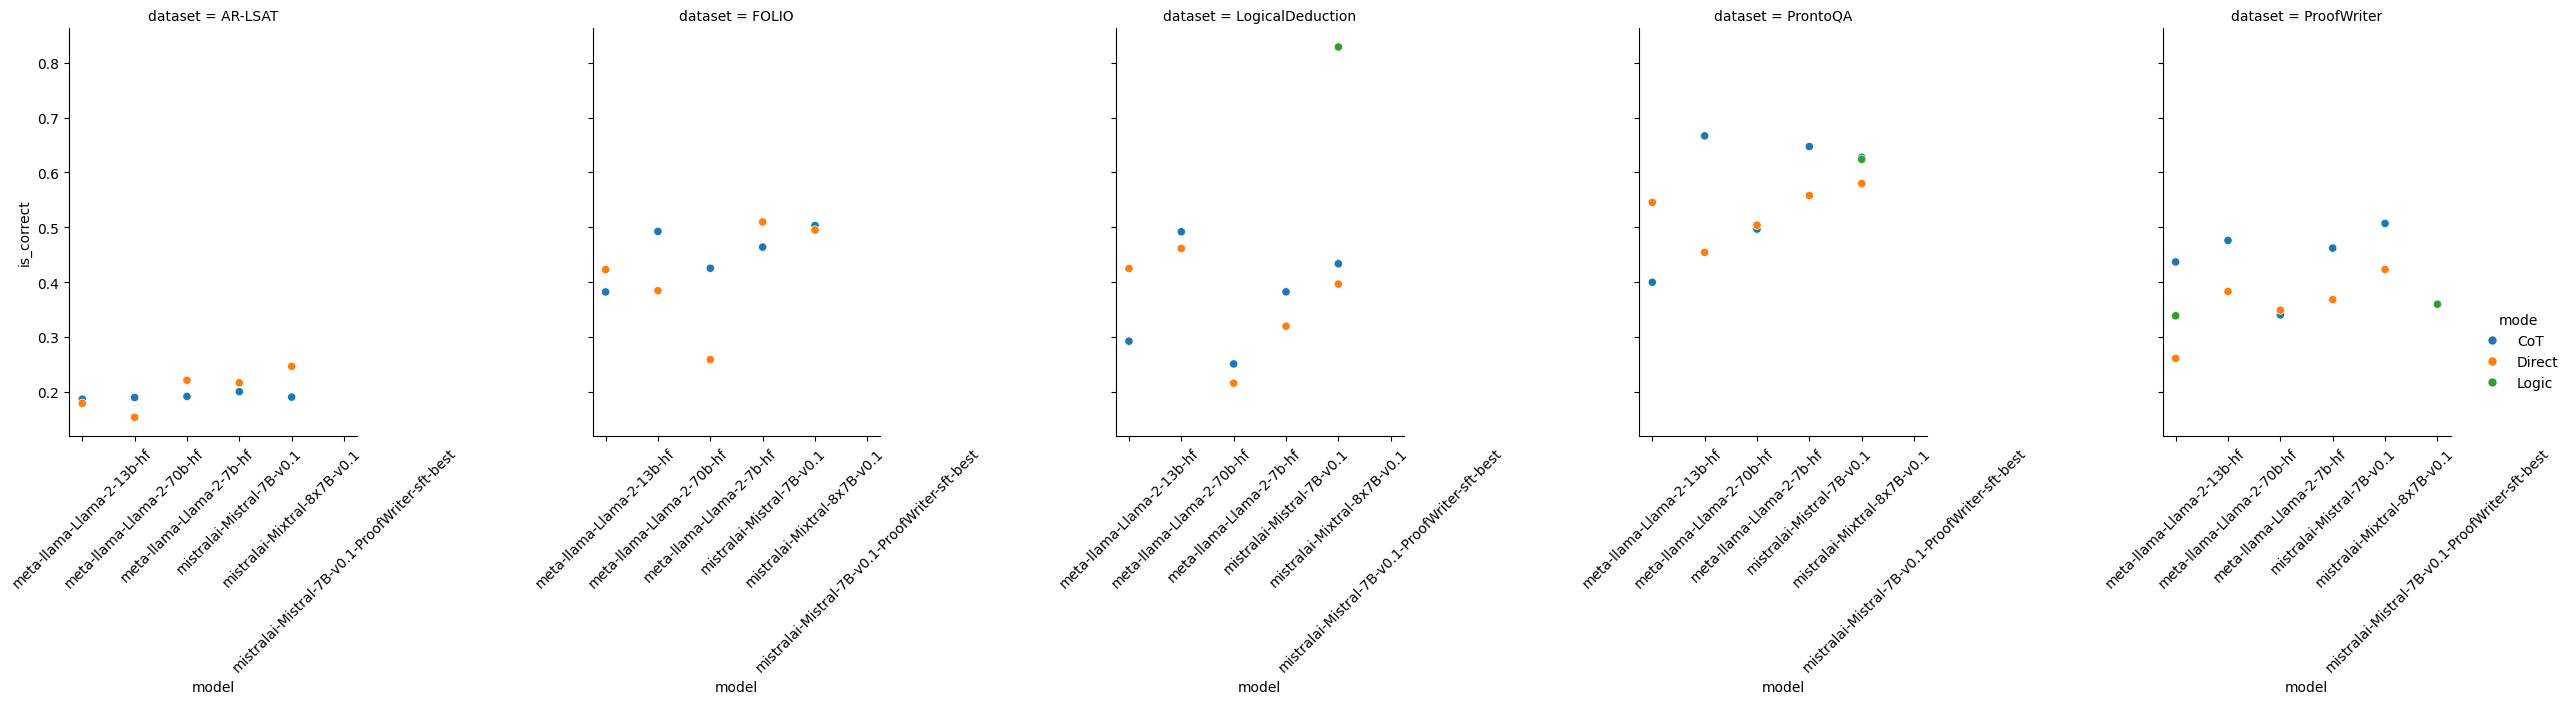

In [27]:
sns.relplot(data=df_total4,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [28]:
df_total4

,model,dataset,mode,is_correct,is_empty
0,meta-llama-Llama-2-13b-hf,AR-LSAT,CoT,0.186916,0.0
1,meta-llama-Llama-2-13b-hf,AR-LSAT,Direct,0.179487,0.0
2,meta-llama-Llama-2-13b-hf,FOLIO,CoT,0.382353,0.0
3,meta-llama-Llama-2-13b-hf,FOLIO,Direct,0.423077,0.0
4,meta-llama-Llama-2-13b-hf,LogicalDeduction,CoT,0.292683,0.0
5,meta-llama-Llama-2-13b-hf,LogicalDeduction,Direct,0.425000,0.0
6,meta-llama-Llama-2-13b-hf,ProntoQA,CoT,0.400000,0.0
7,meta-llama-Llama-2-13b-hf,ProntoQA,Direct,0.545455,0.0
8,meta-llama-Llama-2-13b-hf,ProofWriter,CoT,0.437037,0.0
9,meta-llama-Llama-2-13b-hf,ProofWriter,Direct,0.261307,0.0


In [29]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [30]:
df_total3

,model,dataset,mode,is_correct,is_empty
0,meta-llama-Llama-2-13b-hf,AR-LSAT,CoT,0.086580,0.536797
1,meta-llama-Llama-2-13b-hf,AR-LSAT,Direct,0.030303,0.831169
2,meta-llama-Llama-2-13b-hf,FOLIO,CoT,0.063725,0.833333
3,meta-llama-Llama-2-13b-hf,FOLIO,Direct,0.053922,0.872549
4,meta-llama-Llama-2-13b-hf,LogicalDeduction,CoT,0.120000,0.590000
5,meta-llama-Llama-2-13b-hf,LogicalDeduction,Direct,0.056667,0.866667
6,meta-llama-Llama-2-13b-hf,ProntoQA,CoT,0.044000,0.890000
7,meta-llama-Llama-2-13b-hf,ProntoQA,Direct,0.060000,0.890000
8,meta-llama-Llama-2-13b-hf,ProofWriter,CoT,0.049167,0.887500
9,meta-llama-Llama-2-13b-hf,ProofWriter,Direct,0.043333,0.834167


In [31]:
print(df_total3.to_string())

                                             model           dataset    mode  is_correct  is_empty
0                        meta-llama-Llama-2-13b-hf           AR-LSAT     CoT    0.086580  0.536797
1                        meta-llama-Llama-2-13b-hf           AR-LSAT  Direct    0.030303  0.831169
2                        meta-llama-Llama-2-13b-hf             FOLIO     CoT    0.063725  0.833333
3                        meta-llama-Llama-2-13b-hf             FOLIO  Direct    0.053922  0.872549
4                        meta-llama-Llama-2-13b-hf  LogicalDeduction     CoT    0.120000  0.590000
5                        meta-llama-Llama-2-13b-hf  LogicalDeduction  Direct    0.056667  0.866667
6                        meta-llama-Llama-2-13b-hf          ProntoQA     CoT    0.044000  0.890000
7                        meta-llama-Llama-2-13b-hf          ProntoQA  Direct    0.060000  0.890000
8                        meta-llama-Llama-2-13b-hf       ProofWriter     CoT    0.049167  0.887500
9         

In [32]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


In [33]:
path="/mnt/evafs/groups/luckner-lab/models/mistralai/Mistral-7B-v0.1/LogicalDeduction/sft/runs/Jun11_22-53-05_dgx-4.eden" #folderpath
df=tflog2pandas(path)

In [48]:
df.metric.unique()

array(['train/loss', 'train/grad_norm', 'train/learning_rate',
       'train/epoch', 'eval/loss', 'eval/runtime',
       'eval/samples_per_second', 'eval/steps_per_second',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second', 'train/total_flos',
       'train/train_loss'], dtype=object)

In [35]:
df

,metric,value,step
0,train/loss,3.482000e-01,10.0
1,train/loss,9.910000e-02,20.0
2,train/loss,5.540000e-02,30.0
3,train/loss,4.700000e-02,40.0
4,train/loss,4.270000e-02,50.0
...,...,...,...
0,train/train_runtime,7.297424e+02,396.0
0,train/train_samples_per_second,2.168000e+00,396.0
0,train/train_steps_per_second,5.430000e-01,396.0
0,train/total_flos,1.106620e+17,396.0


In [50]:
# sns.lineplot(data=df.loc[df.metric=="eval/loss",:],x="step",y="value").set(ylabel="Train Loss", title="LogicalDeduction")

[Text(0, 0.5, 'Train Loss'), Text(0.5, 1.0, 'LogicalDeduction')]

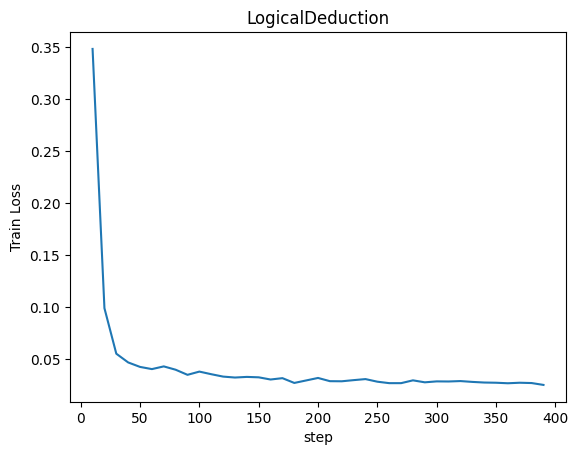

In [37]:
sns.lineplot(data=df.loc[df.metric=="train/loss",:],x="step",y="value").set(ylabel="Train Loss", title="LogicalDeduction")

In [38]:
# sns.relplot(data=df,x="step",y="value",row="metric",kind="line")

In [39]:
df.loc[df.metric=="ppo/policy/ratio",:]

,metric,value,step


<Axes: xlabel='step', ylabel='value'>

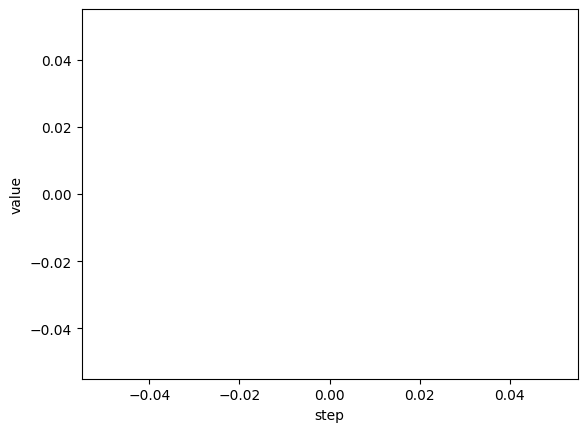

In [40]:
sns.lineplot(data=df.loc[df.metric=="objective/kl",:],x="step",y="value")

In [41]:
bool(0)

False

<Axes: xlabel='step', ylabel='value'>

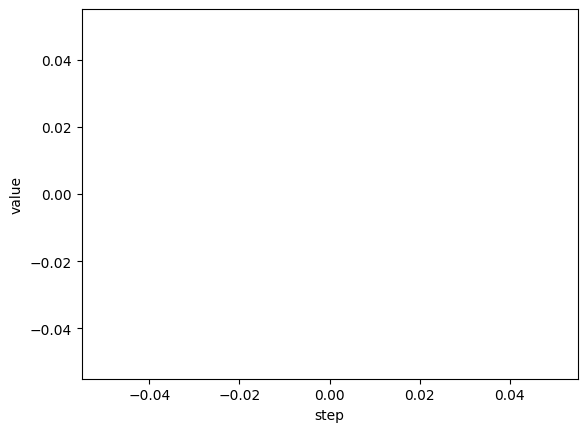

In [42]:
sns.lineplot(data=df.loc[df.metric=="ppo/policy/approxkl",:],x="step",y="value")

<Axes: xlabel='step', ylabel='value'>

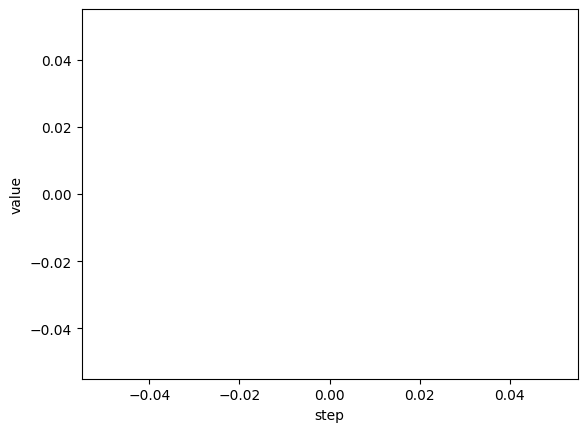

In [43]:
sns.lineplot(data=df.loc[df.metric=="ppo/policy/loss",:],x="step",y="value")

<Axes: xlabel='step', ylabel='value'>

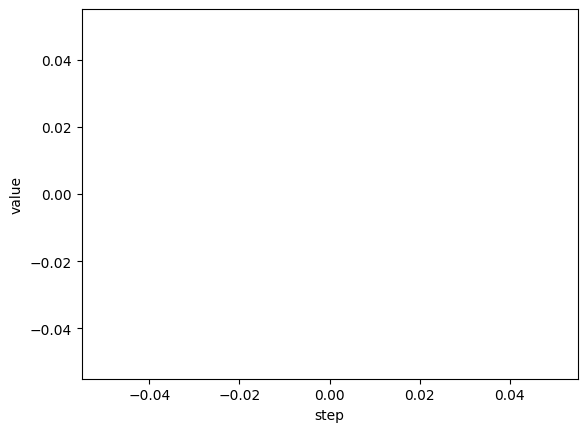

In [44]:
sns.lineplot(data=df.loc[df.metric=="ppo/policy/approxkl",:],x="step",y="value")

In [45]:
df.loc[df.metric=="env/reward_mean",:]

,metric,value,step


<Axes: xlabel='step', ylabel='value'>

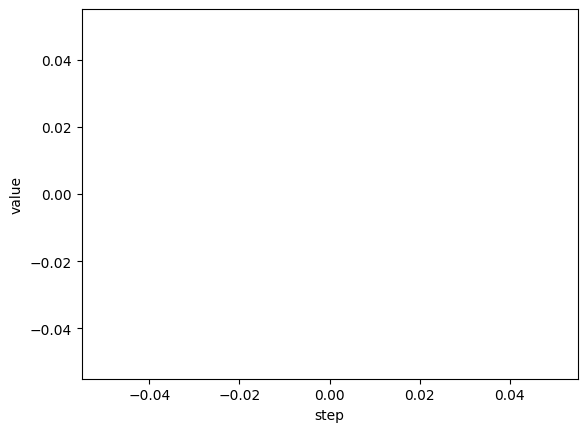

In [46]:
sns.lineplot(data=df.loc[df.metric=="env/reward_mean",:],x="step",y="value")

In [47]:
dataset_name="x"

In [2]:
prompt_file = f'./models/prompts/{dataset_name}.txt'

In [3]:
prompt_file

'./models/prompts/x.txt'